In [65]:
!hydromt update sfincs ./sfincs_vientiane_model -o ./sfincs_vientiane_pluvial -i vientiane_pluvial_update.ini -vv --dd

2022-07-12 15:12:36,860 - update - log - DEBUG - Appending log messages to file C:\Users\ampolini\Workingfolder\hydromt_sfincs-main\examples\sfincs_vientiane_pluvial\hydromt.log.
2022-07-12 15:12:36,861 - update - log - INFO - HydroMT version: 0.4.5
2022-07-12 15:12:36,861 - update - main - INFO - Updating sfincs model at C:\Users\ampolini\Workingfolder\hydromt_sfincs-main\examples\sfincs_vientiane_model (r).
2022-07-12 15:12:36,861 - update - main - INFO - Output dir: C:\Users\ampolini\Workingfolder\hydromt_sfincs-main\examples\sfincs_vientiane_pluvial
2022-07-12 15:12:36,862 - update - main - INFO - User settings:
2022-07-12 15:12:36,884 - update - model_plugins - DEBUG - Loaded model plugin 'sfincs = hydromt_sfincs.sfincs.SfincsModel' (0.2.1)
2022-07-12 15:12:36,884 - update - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v0.2.1).
2022-07-12 15:12:36,885 - update - data_adapter - INFO - Adding deltares_data v0.0.6 sources from https://github.com/DirkEilander/hydr

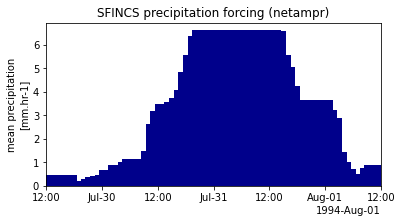

In [66]:
%matplotlib inline
from hydromt_sfincs import SfincsModel
import matplotlib.pyplot as plt
mod = SfincsModel(root="sfincs_vientiane_pluvial", mode="r")
mod.forcing.pop('dis', None)  # let's focus on precip for now
_ = mod.plot_forcing()

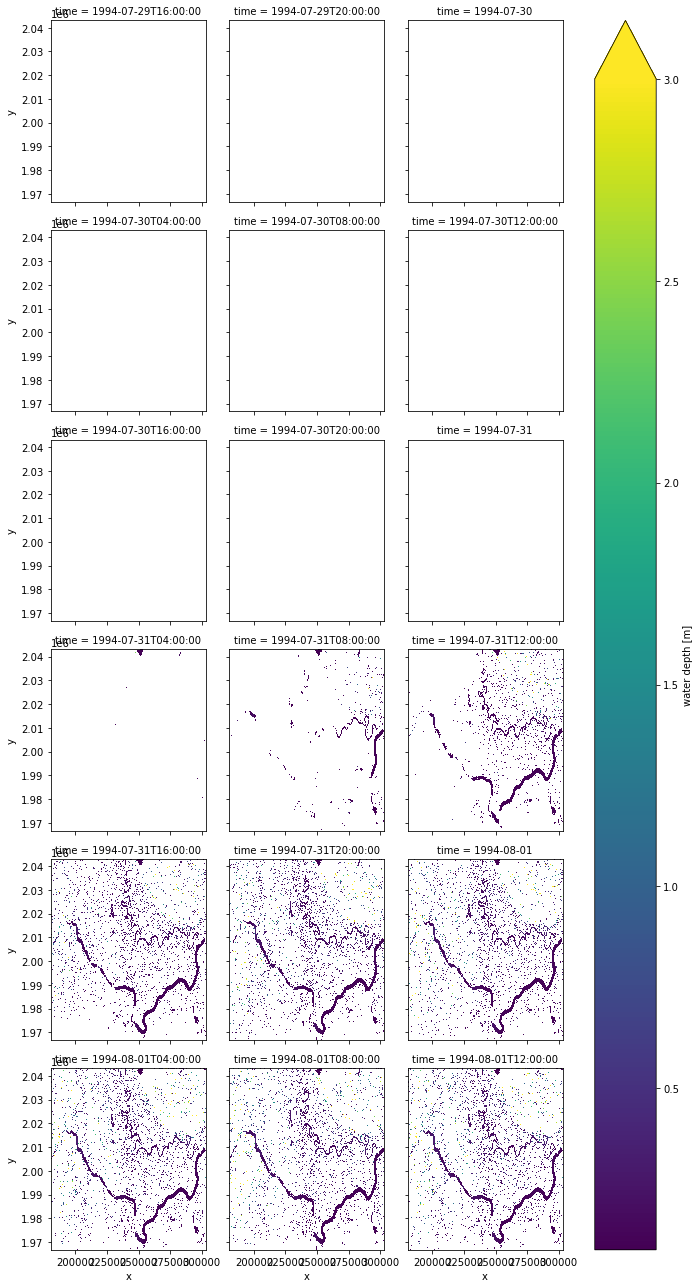

In [67]:
# h from sfincs_map contains the water depths for each cell face
# here we plot the water level every 4th hour

h = mod.results["h"].where(mod.results["h"] > 0.1)
h.attrs.update(long_name="water depth", unit="m")
h.sel(time=h["time"].values[4::4]).plot(col="time", col_wrap=3, vmax=3)

In [68]:
# import dependencies
import xarray as xr
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import hydromt
from hydromt_sfincs import SfincsModel

In [69]:
sfincs_root = "sfincs_vientiane_pluvial"  # (relative) path to sfincs root
mod = SfincsModel(sfincs_root, mode="r", deltares_data= True)

Overwriting data source era5_hourly.
Overwriting data source gcn250.
Overwriting data source merit_hydro.
Overwriting data source rivers_lin2019_v1.
Overwriting data source vito.


In [70]:
hmax = mod.results['hmax']
hmax = hmax.reindex(y=list(reversed(hmax['y'].values))) # change orientation to N -> S
hmax.raster.to_raster(join(mod.root, 'gis', 'hmax.tif'), compress='LZW')

In [72]:
print(mod.data_catalog["gswo"])
gswo = mod.data_catalog.get_rasterdataset("gswo", buffer=10)
# permanent water where water occurence > 5%
gswo_mask = gswo.raster.reproject_like(mod.staticmaps, method="max") <= 3

nodata value missing for p:\wflow_global\hydromt\hydrography\gswo\occur.vrt


{'category': 'hydrography',
 'data_type': 'RasterDataset',
 'driver': 'raster',
 'paper_doi': '10.1038/nature20584',
 'paper_ref': 'Pekel et al. (2016)',
 'path': 'p:\\wflow_global\\hydromt\\hydrography\\gswo\\occur.vrt',
 'source_url': 'https://global-surface-water.appspot.com/download',
 'source_version': 'v1_1_2019'}


In [73]:
hmin = 0.1  # minimum flood depth [m] to plot
da_hmax = mod.results["hmax"]  # hmax is computed from zsmax - zb
# get overland flood depth with GSWO and set minimum flood depth
da_hmax_fld = da_hmax.where(gswo_mask).where(da_hmax > hmin)
# update attributes for colorbar label later
da_hmax.attrs.update(long_name="flood depth", unit="m")

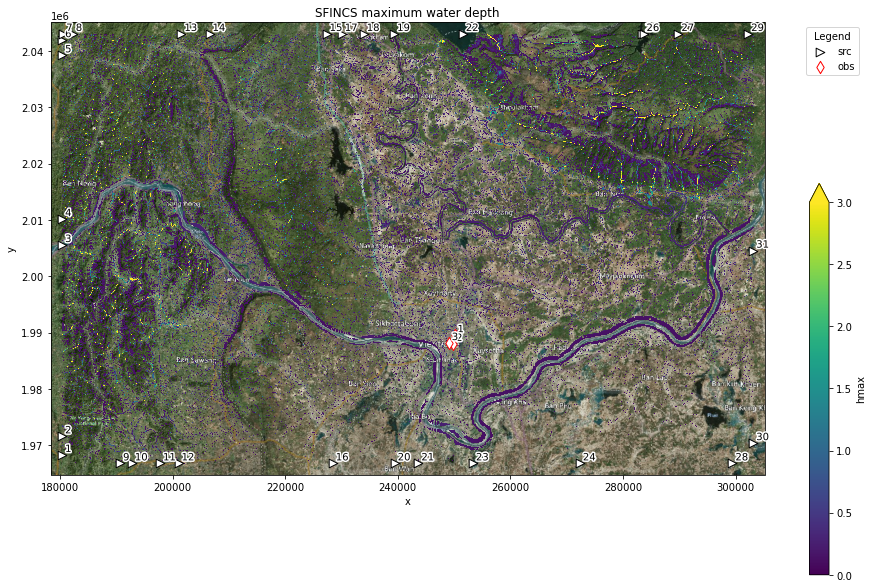

In [74]:
# create hmax plot and save to mod.root/figs/hmax.png
fig, ax = mod.plot_basemap(
    fn_out=None,
    variable=None,
    bmap="sat",
    geoms=["src", "obs"],
    plot_bounds=False,
    figsize=(16, 12),
)
# plot overland flooding based on gswo mask and mimum flood depth
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}
cax_fld = da_hmax_fld.plot(
    ax=ax, vmin=0, vmax=3.0, cmap=plt.cm.viridis, cbar_kwargs=cbar_kwargs
)

ax.set_title(f"SFINCS maximum water depth")
plt.savefig(join(mod.root, 'figs', 'hmax.png'), dpi=225, bbox_inches="tight")

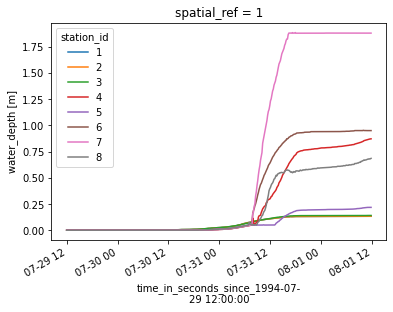

In [75]:
# point_h contains the water depths at the sfincs.obs gauge locations
# see mod.plot_basemaps (or next figure) for the location of the observation points
# make sure that the point ore not negative
h_point = mod.results["point_h"].rename({"stations": "station_id"})
h_point["station_id"] = h_point["station_id"].astype(int)
_ = h_point.plot.line(
    x="time",
)
plt.savefig(join(mod.root, 'figs', 'spatial_ref.png'), dpi=225, bbox_inches="tight")

In [76]:
import pandas as pd
h_df = h_point.reset_coords(drop=True).to_dataframe().unstack()
pd.set_option ('display.max_rows', None)
h_df.columns =  h_point['station_id'].values
h_df[6]>0.1

time
1994-07-29 12:00:00.000000000    False
1994-07-29 12:10:56.264343261    False
1994-07-29 12:21:02.046875000    False
1994-07-29 12:31:40.963745117    False
1994-07-29 12:41:46.746093750    False
1994-07-29 12:51:52.528808593    False
1994-07-29 13:02:31.445556640    False
1994-07-29 13:12:37.228027343    False
1994-07-29 13:22:43.010742187    False
1994-07-29 13:33:21.927734375    False
1994-07-29 13:43:27.709960937    False
1994-07-29 13:53:33.492187500    False
1994-07-29 14:04:12.409179687    False
1994-07-29 14:14:18.191894531    False
1994-07-29 14:24:23.974609375    False
1994-07-29 14:35:02.891601562    False
1994-07-29 14:45:08.673828125    False
1994-07-29 14:55:14.456054687    False
1994-07-29 15:05:53.373046875    False
1994-07-29 15:15:59.155273437    False
1994-07-29 15:26:04.938476562    False
1994-07-29 15:36:43.855468750    False
1994-07-29 15:46:49.637695312    False
1994-07-29 15:56:55.419921875    False
1994-07-29 16:07:34.336914062    False
1994-07-29 16:17:40.

In [78]:
sum(h_df[6])/6

23.692426045735676